# Workflow Final

### Sommaire

* [1. Import de librairies](#imports)
* [2. Variables globales](#variables)
* [3. Import du classifieur (CNN)](#classifieur)
* [4. Import du débruiteur](#denoiser)
* [5. Import du modèle de captioning (CNN + RNN)](#captioning)
* [6. Construction du pipeline](#pipeline)
* [7. Chargement de données](#donnees)
* [8. Inférence (Prédictions)](#inference)
* [9. Affichage de quelques prédictions](#ploting)

### 1. Import de librairies <a class="anchor" id="imports"></a>

In [61]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from PIL import Image

In [78]:
tf.__version__

'2.15.0'

### 2. Variables globales <a class="anchor" id="variables"></a>

In [62]:
CLASSIFIER_IMG_SIZE = 64
DENOISER_IMG_SIZE = 64               
BATCH_SIZE = 8     
DATASET_PATH = './dataset_livrable_1'   
save_folder = './denoised_images'
max_length = 33
attention_features_shape = 64
model_name = 'InceptionV3'

### 3. Import du classifieur (CNN) <a class="anchor" id="classifieur"></a>

In [63]:
classifier = tf.keras.models.load_model('classifier')
# classifier.summary()

### 4. Import du débruiteur <a class="anchor" id="denoiser"></a>

In [64]:
denoiser = tf.keras.models.load_model('denoiser')
# denoiser.summary()

### 5. Import du modèle de captioning (CNN + RNN) <a class="anchor" id="captioning"></a>

In [65]:
encoder = tf.keras.models.load_model('captioner_encoder')
# encoder.summary()
decoder = tf.keras.models.load_model('captioner_decoder')
# decoder.summary()



### 6. Construction du pipeline <a class="anchor" id="pipeline"></a>

In [66]:
class Pipeline():
    def __init__(self, classifier, denoiser=None, captioner=None, img_size=64, denoiser_img_size=224):
        self.classifier = classifier
        self.denoiser = denoiser
        self.captioner = captioner
        self.img_size = img_size
        self.denoiser_img_size = denoiser_img_size
        self.image_features_extract_model = self.create_image_features_model('InceptionV3')
        # tokenizer
        with open('tokenizer.pickle', 'rb') as handle:
            self.tokenizer = pickle.load(handle)
        
    def binary_label(self, images, labels, dataset):
        """Fonction pour convertir les étiquettes en format binaire."""
        target_label = dataset.class_names.index('Photo')
        binary_labels = tf.where(labels == target_label, 1, 0)
        return images, binary_labels

    def select_photos(self, predictions, dataset, batch_size=16):
        batch = []
        for pred, (image, label) in zip(predictions, dataset.unbatch()):
            if pred == 1:  # If the predicted class for this image is 1
                batch.append(image)
                if len(batch) == batch_size:
                    yield np.stack(batch), np.stack(batch)
                    batch = []
        if batch:  # If there are any images left in the batch
            yield np.stack(batch), np.stack(batch)

    def create_image_features_model(self, model_name):
        base_models = {
            'InceptionV3': tf.keras.applications.InceptionV3,
            'ResNet50': tf.keras.applications.ResNet50,
            'EfficientNetB0': tf.keras.applications.EfficientNetB0
        }
        if model_name not in base_models:
            raise ValueError("Modèle non supporté.")
        image_model = base_models[model_name](include_top=False, weights='imagenet')
        new_input = image_model.input
        hidden_layer = image_model.layers[-1].output
        return tf.keras.Model(new_input, hidden_layer)
    
    def load_image(self, image_path, model_name):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        if model_name == 'InceptionV3':
            img = tf.image.resize(img, (299, 299))
            img = tf.keras.applications.inception_v3.preprocess_input(img)
        elif model_name == 'ResNet50':
            img = tf.image.resize(img, (224, 224))
            img = tf.keras.applications.resnet.preprocess_input(img)
        elif model_name == 'EfficientNetB0':
            img = tf.image.resize(img, (224, 224))
            img = tf.keras.applications.efficientnet.preprocess_input(img)
        return img, image_path
    
    def evaluate(self, image):
        attention_plot = np.zeros((max_length, attention_features_shape))

        hidden = tf.zeros((1, 512))

        temp_input = tf.expand_dims(self.load_image(image, model_name)[0], 0)
        img_tensor_val = self.image_features_extract_model(temp_input)
        img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

        features = encoder(img_tensor_val)

        dec_input = tf.expand_dims([self.tokenizer.word_index['<start>']], 0)
        result = []

        for i in range(max_length):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

            predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
            result.append(self.tokenizer.index_word[predicted_id])

            if self.tokenizer.index_word[predicted_id] == '<end>':
                return result, attention_plot

            dec_input = tf.expand_dims([predicted_id], 0)

        attention_plot = attention_plot[:len(result), :]
        return result, attention_plot

    # Function allowing the representation of attention at the image level
    def plot_attention(self, image, result, attention_plot):
        temp_image = np.array(Image.open(image))

        fig = plt.figure(figsize=(10, 10))

        len_result = len(result)
        for l in range(len_result):
            temp_att = np.resize(attention_plot[l], (8, 8))
            ax = fig.add_subplot(len_result//2, len_result//2, l+1)
            ax.set_title(result[l])
            img = ax.imshow(temp_image)
            ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

        plt.tight_layout()
        plt.show()

    def __call__(self, dataset):
        # 1. Transform labels to binary
        dataset = dataset.map(lambda x, y: self.binary_label(x, y, dataset))

        # 2. Normalize image data
        normalization_layer = tf.keras.layers.Rescaling(1./255)
        dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

        # 3. Use the classifier model
        classifier_predictions = self.classifier.predict(dataset)

        # 4. Select only the photos given the previous classification data
        classifier_predictions_labels = (classifier_predictions > 0.5).astype(int)
        selected_photos = self.select_photos(classifier_predictions_labels, dataset)

        # 4.1 Create a Dataset from the "selected_photos" generator
        photo_dataset = tf.data.Dataset.from_generator(
            lambda: selected_photos,
            output_signature=(
                tf.TensorSpec(shape=(None, self.img_size, self.img_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(None, self.img_size, self.img_size, 3), dtype=tf.float32)
            )
        )
        # 5. Resize the selected photos to (None, denoiser_img_size, denoiser_img_size, 3)
        resized_photos = photo_dataset.map(lambda x, y: (tf.image.resize(x, [self.denoiser_img_size, self.denoiser_img_size]), y))
        
        # 6. Apply denoising to the photos
        denoised_images = self.denoiser.predict(resized_photos)

        # 7. Save the denoised images
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        for i, image in enumerate(denoised_images):
            image_path = os.path.join(save_folder, f'image{i}.jpg')
            plt.imsave(image_path, image) 

        # 8. Generate a caption for the denoised image using the captioner model
        folder_contents = os.listdir(save_folder)
        full_paths = [os.path.join(save_folder, name) for name in folder_contents]
        for im in range(len(full_paths)):
            predicted_caption, attention_plot = self.evaluate(full_paths[im])
            yield (full_paths[im], predicted_caption, attention_plot)

### 7. Chargement de données <a class="anchor" id="donnees"></a>

In [67]:
# Load the dataset
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,   
    validation_split=0.2,   
    subset="training", 
    seed=123,  
    shuffle=True,  
    image_size=(CLASSIFIER_IMG_SIZE, CLASSIFIER_IMG_SIZE), 
    batch_size=BATCH_SIZE,     
    label_mode='int'  
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(CLASSIFIER_IMG_SIZE, CLASSIFIER_IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'  
)

Found 41398 files belonging to 5 classes.
Using 33119 files for training.
Found 41398 files belonging to 5 classes.
Using 8279 files for validation.


### 8. Inférence (Prédictions) <a class="anchor" id="inference"></a>

In [68]:
pipeline = Pipeline(classifier=classifier, denoiser=denoiser, img_size=CLASSIFIER_IMG_SIZE, denoiser_img_size=DENOISER_IMG_SIZE)

In [69]:
pipeline_generator = pipeline(train_set)

### 9. Affichage de quelques prédictions <a class="anchor" id="ploting"></a>

In [75]:
im, predicted_caption, attention_plot = next(pipeline_generator)
print(im, predicted_caption, attention_plot)

./denoised_images/image2037.jpg ['people', 'walking', 'through', 'the', 'street', 'with', 'people', 'and', 'bikes', '<end>'] [[2.09186855e-03 1.68905570e-03 5.11926773e-05 ... 4.23995458e-04
  3.61854327e-03 3.92106274e-04]
 [1.07410485e-02 1.18497964e-02 3.53117473e-03 ... 2.02265708e-03
  4.48582694e-03 1.36014074e-03]
 [7.26285763e-03 2.03542644e-03 2.50308134e-04 ... 1.53239339e-03
  2.91609229e-03 6.11113210e-04]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


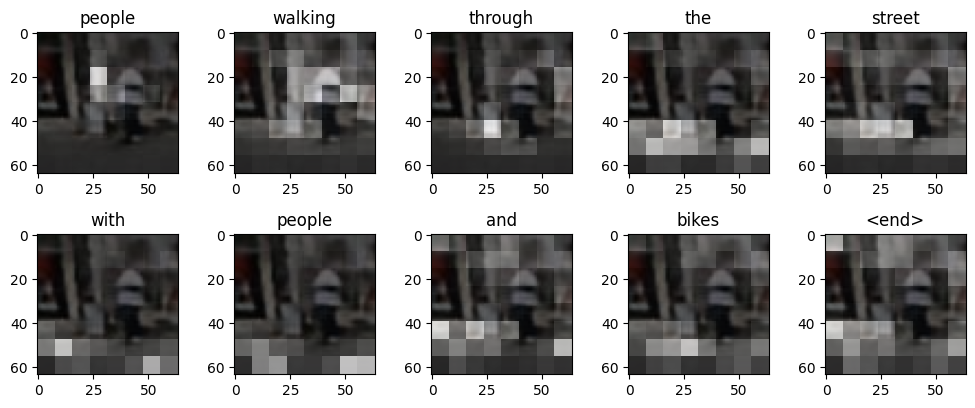

In [76]:
pipeline.plot_attention(im, predicted_caption, attention_plot)